## Video generation using GANs with LSTMs

In [56]:
# from keras.datasets import mnist
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
import random

%matplotlib inline

In [2]:
A = mnist.load_data()

10985472/11490434 [===========================>..] - ETA: 0s

In [25]:
X = A[0]
Y = A[1]

x_train = X[0]
y_train = X[1]

x_test = Y[0]
y_test = Y[1]

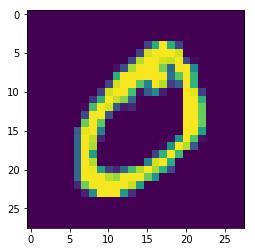

In [35]:
plt.imshow(x_train[1])

In [54]:
def insert_num_background(location, img, background_dim):

    background = np.zeros([background_dim[0],background_dim[1]])
    x = location[0]
    y = location[1]
    
    background[x:x+img.shape[0], y:y+img.shape[1]] = img
    return background

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


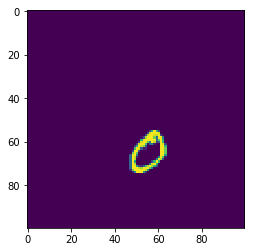

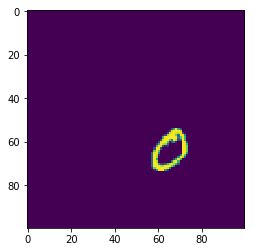

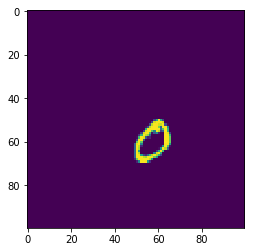

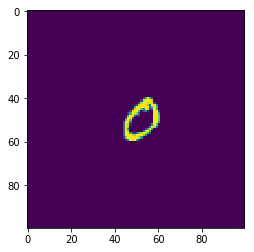

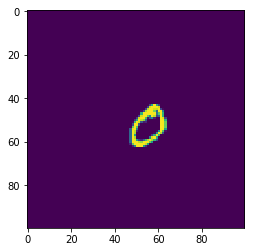

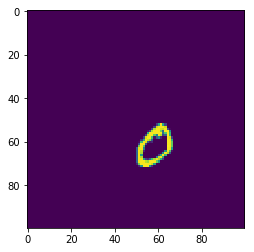

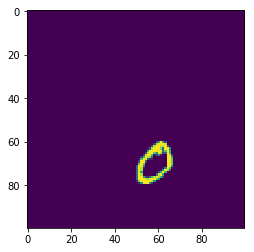

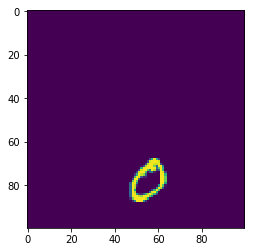

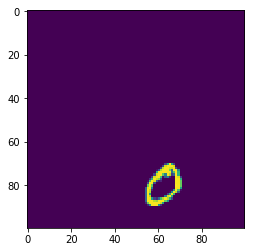

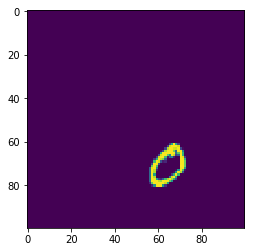

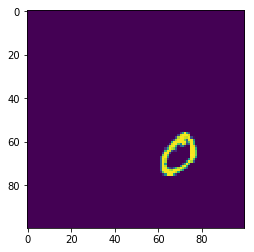

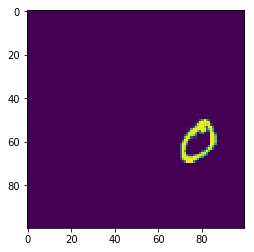

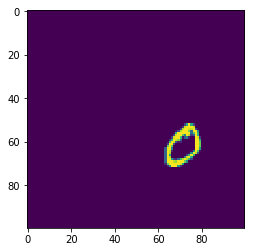

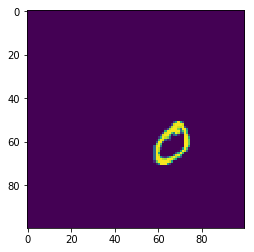

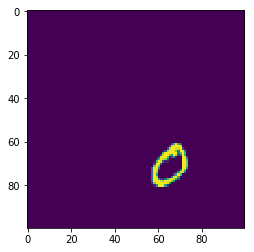

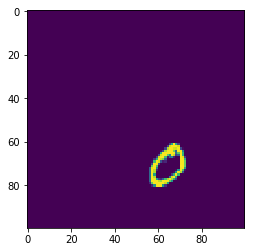

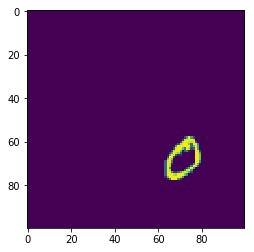

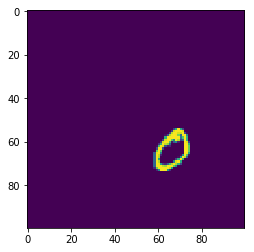

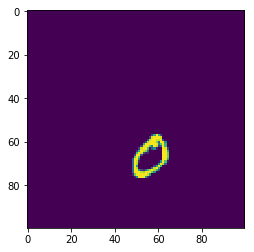

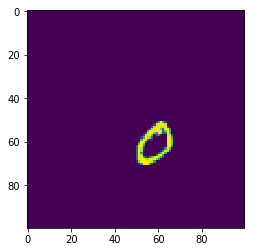

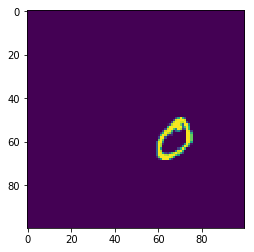

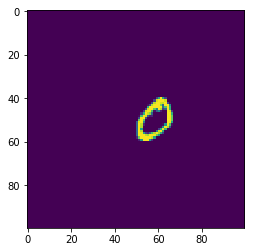

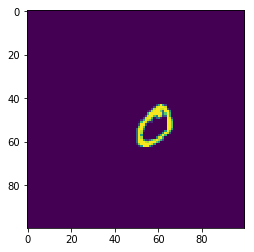

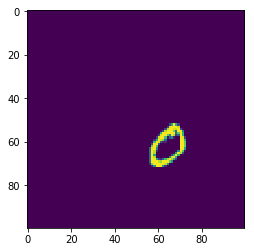

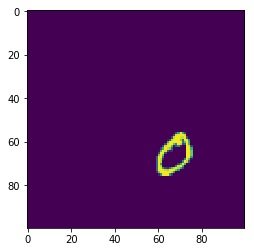

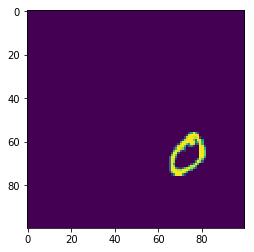

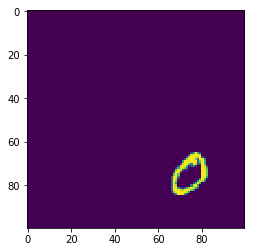

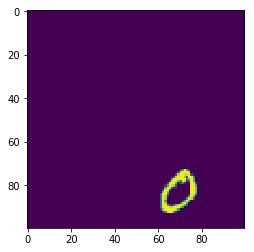

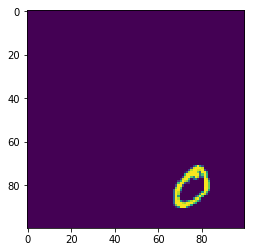

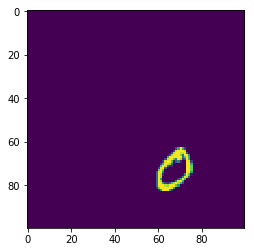

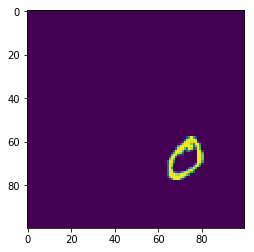

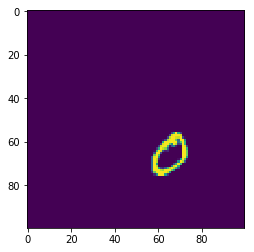

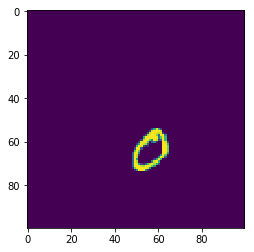

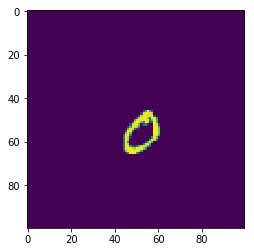

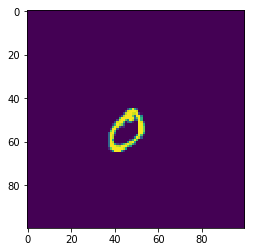

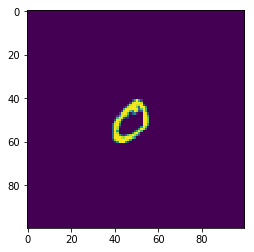

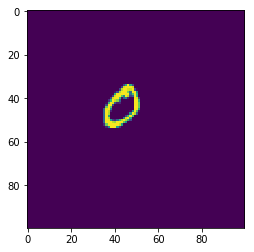

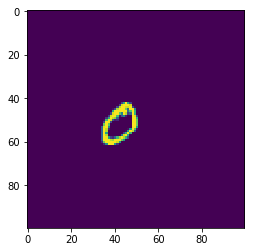

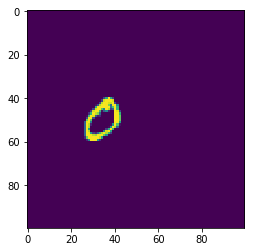

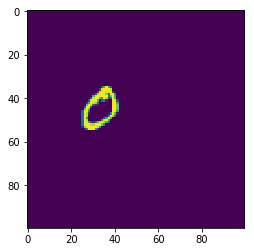

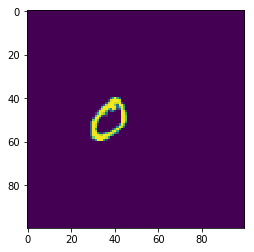

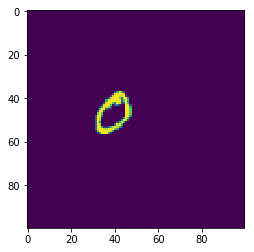

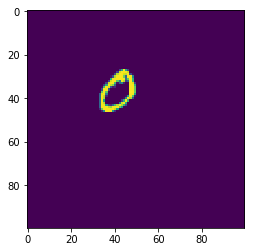

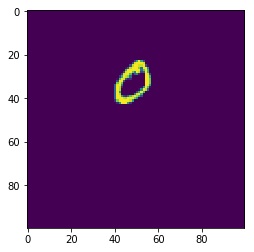

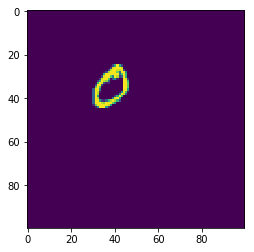

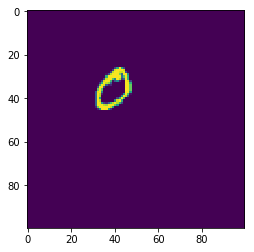

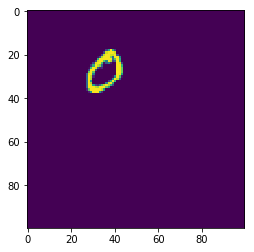

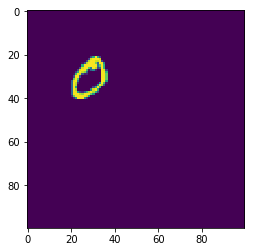

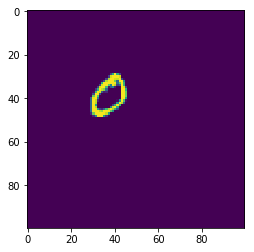

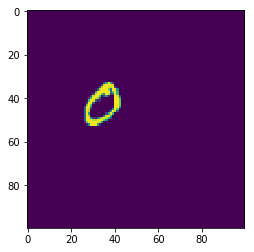

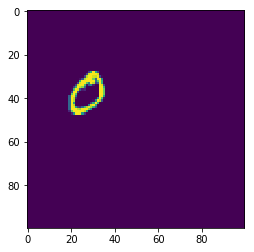

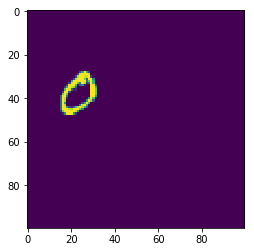

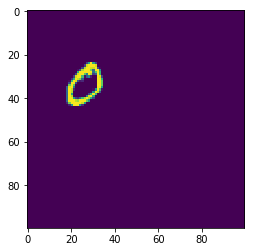

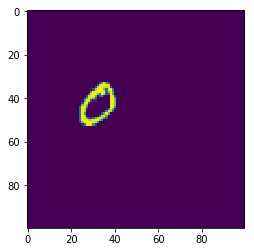

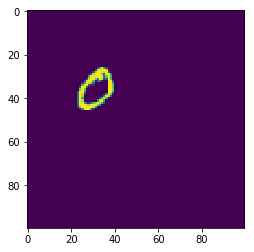

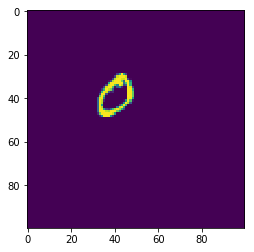

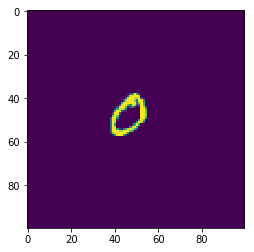

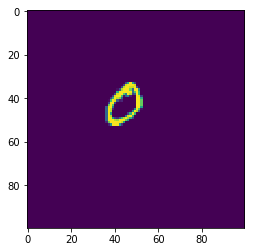

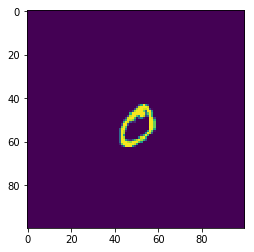

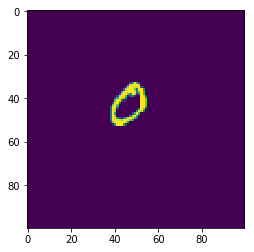

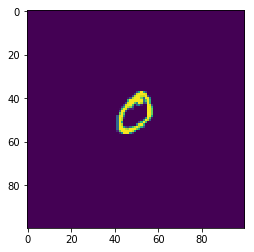

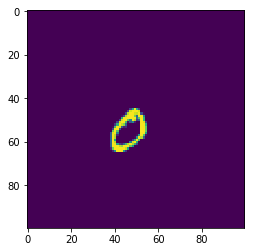

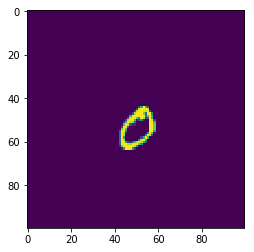

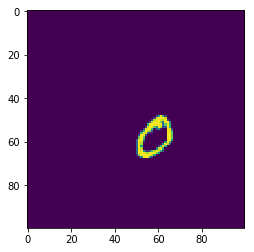

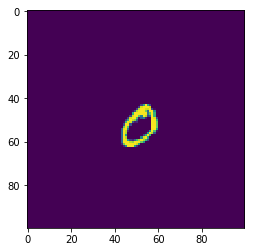

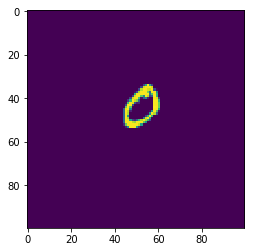

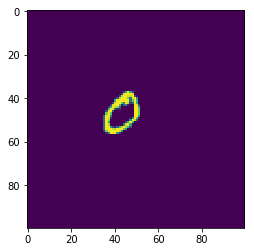

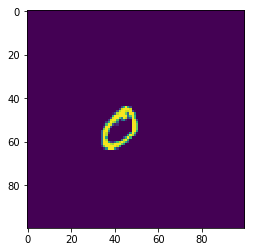

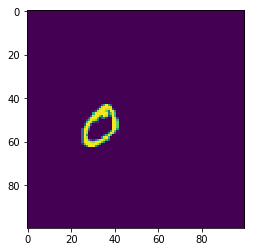

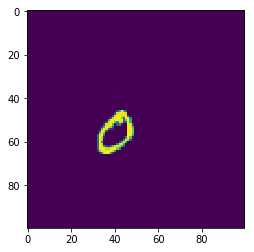

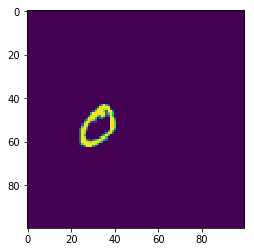

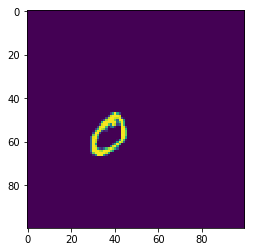

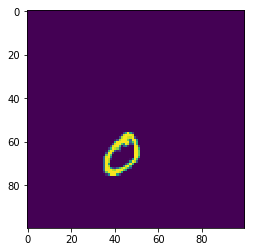

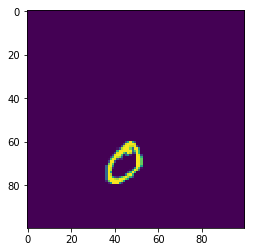

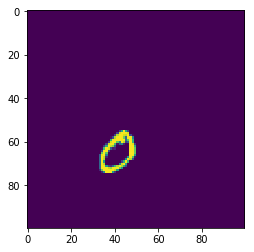

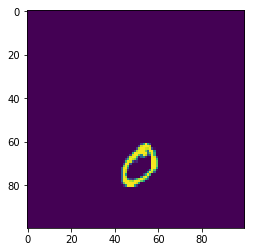

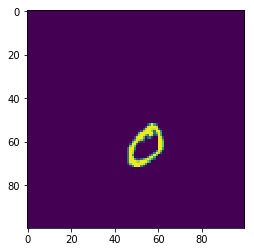

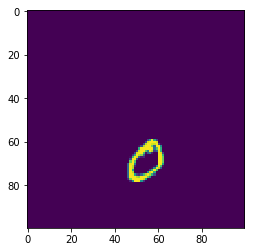

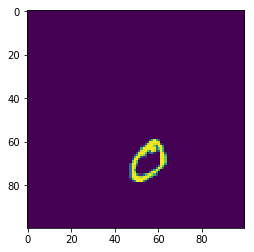

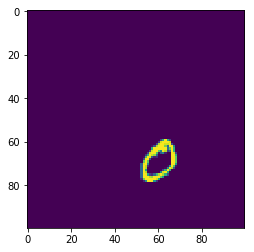

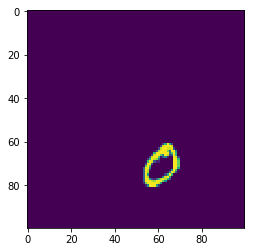

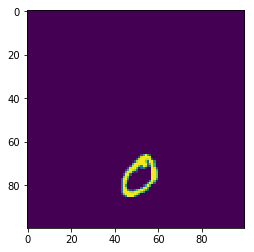

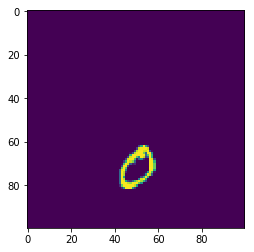

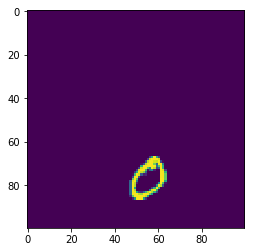

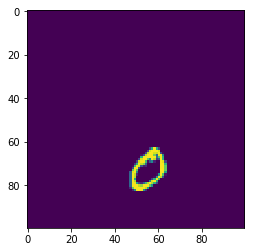

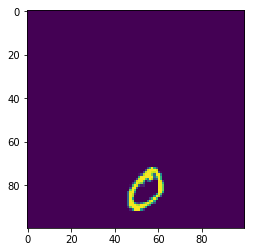

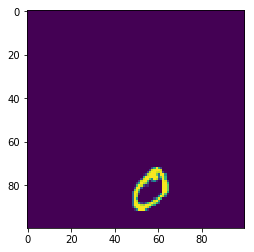

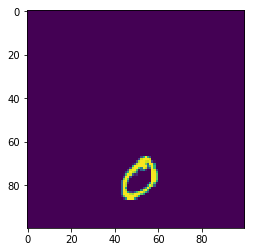

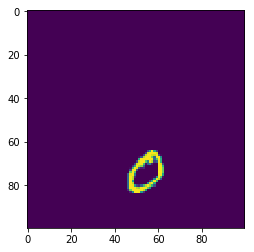

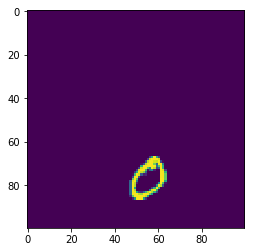

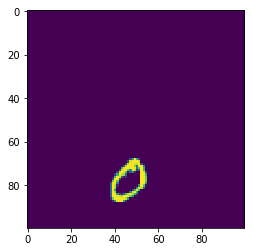

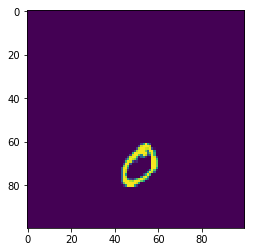

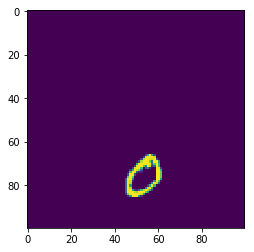

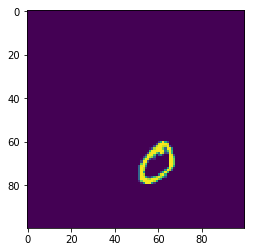

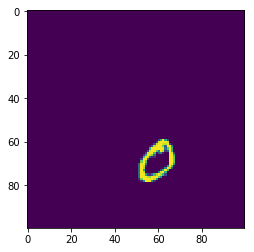

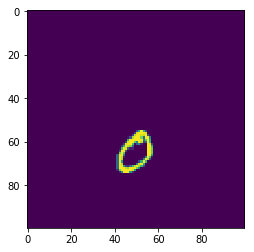

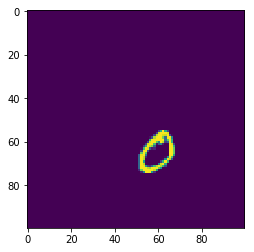

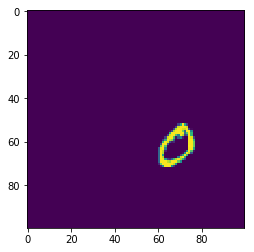

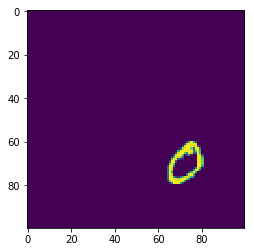

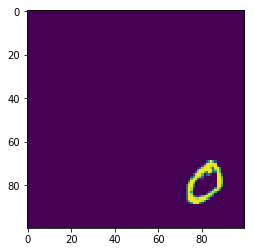

In [65]:
video_1 = []
n_iters = 100
x = 50
y = 50

for i in range(n_iters):
    x_min = max(0, x - 10)
    x_max = min(99-28, x + 10)
    
    y_min = max(0, y - 10)
    y_max = min(99-28, y + 10)
    
    x = random.randint(x_min,x_max)
    y = random.randint(y_min,y_max)
    img = insert_num_background([x,y], x_train[1], [100,100])
    plt.figure()
    plt.imshow(img)

    video_1.append(img)

In [62]:
from __future__ import division
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
from six.moves import xrange

from ops import *
from utils import *

import pandas as pd

# def conv_out_size_same(size, stride):
# return int(math.ceil(float(size) / float(stride)))

class DCGAN(object):
    def __init__(self, sess, input_height=108, input_width=108, crop=True,
         batch_size=64, sample_num = 64, output_height=64, output_width=64,
         y_dim=10, z_dim=100, gf_dim=64, df_dim=64,
         gfc_dim=1024, dfc_dim=1024, c_dim=3, dataset_name='faces',
         input_fname_pattern='*.ppm', checkpoint_dir=None, sample_dir=None):

    """"
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
    """
    self.sess = sess

    self.batch_size = batch_size
    self.sample_num = sample_num

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    # batch normalization : deals with poor initialization helps gradient flow
    self.d_bn1 = batch_norm(name='d_bn1')
    self.d_bn2 = batch_norm(name='d_bn2')

    self.d_bn3 = batch_norm(name='d_bn3')

    self.g_bn0 = batch_norm(name='g_bn0')
    self.g_bn1 = batch_norm(name='g_bn1')
    self.g_bn2 = batch_norm(name='g_bn2')

    self.g_bn3 = batch_norm(name='g_bn3')

    self.dataset_name = dataset_name
    self.input_fname_pattern = input_fname_pattern
    self.checkpoint_dir = checkpoint_dir

    self.data = glob(os.path.join("/data", self.dataset_name, self.input_fname_pattern))
    self.labels = [get_condition(instance) for instance in self.data]
    print (self.labels[:10])

    imreadImg = imread(self.data[0])

    if len(imreadImg.shape) >= 3: #check if image is a non-grayscale image by checking channel number
          self.c_dim = imread(self.data[0]).shape[-1]
    else:
          self.c_dim = 1

    self.grayscale = (self.c_dim == 1)

    self.build_model()

    def build_model(self):
        if self.y_dim:
            self.y = tf.placeholder(tf.float32, [self.batch_size, self.y_dim], name='y')
        else:
            self.y = None

    if self.crop:
      image_dims = [self.output_height, self.output_width, self.c_dim]
    else:
      image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
      tf.float32, [self.batch_size] + image_dims, name='real_images')

    inputs = self.inputs

    self.z = tf.placeholder(
      tf.float32, [None, self.z_dim], name='z')
    self.z_sum = histogram_summary("z", self.z)

    self.G                  = self.generator(self.z, self.y)
    self.D, self.D_logits   = self.discriminator(inputs, self.y, reuse=False)
    self.sampler            = self.sampler(self.z, self.y)
    self.D_, self.D_logits_ = self.discriminator(self.G, self.y, reuse=True)
    
    self.d_sum = histogram_summary("d", self.D)
    self.d__sum = histogram_summary("d_", self.D_)
    self.G_sum = image_summary("G", self.G)

    def sigmoid_cross_entropy_with_logits(x, y):
      try:
        return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)
      except:
        return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, targets=y)

    self.d_loss_real = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(self.D_logits, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(self.D_logits_, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(self.D_logits_, tf.ones_like(self.D_)))

    self.d_loss_real_sum = scalar_summary("d_loss_real", self.d_loss_real)
    self.d_loss_fake_sum = scalar_summary("d_loss_fake", self.d_loss_fake)
                          
    self.d_loss = self.d_loss_real + self.d_loss_fake

    self.g_loss_sum = scalar_summary("g_loss", self.g_loss)
    self.d_loss_sum = scalar_summary("d_loss", self.d_loss)

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()


  def train(self, config):
    d_optim = tf.train.AdamOptimizer(config.learning_rate, beta1=config.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(config.learning_rate, beta1=config.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    try:
      tf.global_variables_initializer().run()
    except:
      tf.initialize_all_variables().run()

    self.g_sum = merge_summary([self.z_sum, self.d__sum,
      self.G_sum, self.d_loss_fake_sum, self.g_loss_sum])
    self.d_sum = merge_summary(
        [self.z_sum, self.d_sum, self.d_loss_real_sum, self.d_loss_sum])
    self.writer = SummaryWriter("./logs", self.sess.graph)

    sample_files = self.data[0:self.sample_num]

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num , self.z_dim))
    sample_labels = self.labels[0:self.sample_num]

    sample = [
        get_image(sample_file,
                  input_height=self.input_height,
                  input_width=self.input_width,
                  resize_height=self.output_height,
                  resize_width=self.output_width,
                  crop=self.crop,
                  grayscale=self.grayscale) for sample_file in sample_files]
    if (self.grayscale):
      sample_inputs = np.array(sample).astype(np.float32)[:, :, :, None]
    else:
      sample_inputs = np.array(sample).astype(np.float32)

    counter = 1
    start_time = time.time()
    could_load, checkpoint_counter = self.load(self.checkpoint_dir)
    if could_load:
      counter = checkpoint_counter
      print(" [*] Load SUCCESS")
    else:
      print(" [!] Load failed...")

    for epoch in xrange(config.epoch):
      batch_idxs = min(len(self.data), config.train_size) // config.batch_size

      for idx in xrange(0, batch_idxs):
        batch_files = self.data[idx*config.batch_size:(idx+1)*config.batch_size]
        batch = [
            get_image(batch_file,
                      input_height=self.input_height,
                      input_width=self.input_width,
                      resize_height=self.output_height,
                      resize_width=self.output_width,
                      crop=self.crop,
                      grayscale=self.grayscale) for batch_file in batch_files]
        if self.grayscale:
          batch_images = np.array(batch).astype(np.float32)[:, :, :, None]
        else:
          batch_images = np.array(batch).astype(np.float32)

        batch_z = np.random.uniform(-1, 1, [config.batch_size, self.z_dim]) \
              .astype(np.float32)

        batch_labels = self.labels[idx*config.batch_size: (idx+1)*config.batch_size]

        # Update D network
        _, summary_str = self.sess.run([d_optim, self.d_sum],
          feed_dict={ self.inputs: batch_images, self.z: batch_z, self.y: batch_labels })
        self.writer.add_summary(summary_str, counter)

        # Update G network
        _, summary_str = self.sess.run([g_optim, self.g_sum],
          feed_dict={ self.z: batch_z, self.y: batch_labels })
        self.writer.add_summary(summary_str, counter)

        # Run g_optim twice to make sure that d_loss does not go to zero (different from paper)
        _, summary_str = self.sess.run([g_optim, self.g_sum],
          feed_dict={ self.z: batch_z, self.y: batch_labels })
        self.writer.add_summary(summary_str, counter)
        
        errD_fake = self.d_loss_fake.eval({ self.z: batch_z, self.y: batch_labels })
        errD_real = self.d_loss_real.eval({ self.inputs: batch_images, self.y: batch_labels })
        errG = self.g_loss.eval({self.z: batch_z, self.y: batch_labels})
  
        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
          % (epoch, idx, batch_idxs,
            time.time() - start_time, errD_fake+errD_real, errG))

      counter += 1
      if np.mod(counter, 30) == 20:
        try:
          samples, d_loss, g_loss = self.sess.run(
            [self.sampler, self.d_loss, self.g_loss],
            feed_dict={
                self.z: sample_z,
                self.inputs: sample_inputs,
                self.y: sample_labels,
            },
          )
          save_images(samples, image_manifold_size(samples.shape[0]),
                '/output/train_{:02d}_{:04d}.png'.format(epoch, idx))
          print("[Sample] d_loss: %.8f, g_loss: %.8f" % (d_loss, g_loss)) 
        except:
          print("one pic error!...")

        self.save("/output", counter)
        print("After Save")

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      # yb = tf.reshape(y, [self.batch_size, 1, 1, self.y_dim])
      # x = conv_cond_concat(image, yb)

      h0 = conv2d(image, self.df_dim, name='d_h0_conv')
      h0 = tf.layers.batch_normalization(h0, training=True)
      h0 = lrelu(h0)

      h1 = conv2d(h0, self.df_dim*2, name='d_h1_conv')
      h1 = tf.layers.batch_normalization(h1, training=True)
      h1 = lrelu(h1)

      h2 = conv2d(h1, self.df_dim*4, name='d_h2_conv')
      h2 = tf.layers.batch_normalization(h2, training=True)
      h2 = lrelu(h2)

      tags_vectors = tf.expand_dims(tf.expand_dims(y, 1), 2)
      tags_vectors = tf.tile(tags_vectors, [1, 14, 14, 1])
      condition_info = tf.concat([h2, tags_vectors], axis=-1)

      h3 = conv2d(condition_info, self.df_dim*8, name='d_h3_conv')
      h3 = tf.layers.batch_normalization(h3, training=True)
      h3 = lrelu(h3)      

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
      s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
      s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
      s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

      noise_vector = concat([z, y], 1)

      h0 = tf.contrib.layers.fully_connected(
        noise_vector, s_h16*s_w16*self.gf_dim*8,
        weights_initializer=tf.random_normal_initializer(stddev=0.02),
        activation_fn=None
        )

      h0 = tf.layers.batch_normalization(h0, training=True)
      h0 = tf.reshape(h0, [-1, s_h16, s_w16, self.gf_dim*8])
      h0 = tf.nn.relu(h0)

      self.h1, self.h1_w, self.h1_b = deconv2d(
          h0, [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='g_h1', with_w=True)

      h1 = tf.nn.relu(self.g_bn1(self.h1))

      h2, self.h2_w, self.h2_b = deconv2d(
          h1, [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='g_h2', with_w=True)
      h2 = tf.nn.relu(self.g_bn2(h2))

      h3, self.h3_w, self.h3_b = deconv2d(
          h2, [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='g_h3', with_w=True)
      h3 = tf.nn.relu(self.g_bn3(h3))

      h4, self.h4_w, self.h4_b = deconv2d(
          h3, [self.batch_size, s_h, s_w, self.c_dim], name='g_h4', with_w=True)

      return tf.nn.sigmoid(h4)

  def sampler(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      scope.reuse_variables()

      s_h, s_w = self.output_height, self.output_width
      s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
      s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
      s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
      s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

      noise_vector = concat([z, y], 1)

      h0 = tf.contrib.layers.fully_connected(
        noise_vector, s_h16*s_w16*self.gf_dim*8,
        weights_initializer=tf.random_normal_initializer(stddev=0.02),
        activation_fn=None
        )
      
      h0 = tf.layers.batch_normalization(h0, training=True)
      h0 = tf.reshape(h0, [-1, s_h16, s_w16, self.gf_dim*8])
      h0 = tf.nn.relu(h0)

      self.h1, self.h1_w, self.h1_b = deconv2d(
          h0, [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='g_h1', with_w=True)

      h1 = tf.nn.relu(self.g_bn1(self.h1, train = False))

      h2, self.h2_w, self.h2_b = deconv2d(
          h1, [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='g_h2', with_w=True)
      h2 = tf.nn.relu(self.g_bn2(h2, train = False))

      h3, self.h3_w, self.h3_b = deconv2d(
          h2, [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='g_h3', with_w=True)
      h3 = tf.nn.relu(self.g_bn3(h3, train = False))

      h4, self.h4_w, self.h4_b = deconv2d(
          h3, [self.batch_size, s_h, s_w, self.c_dim], name='g_h4', with_w=True)

      return tf.nn.sigmoid(h4)


10